# Avalanche hazard level data exploration and cleansing

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from os import remove
import glob

from utils.latex import LatexHelpers
from utils.data_transformation import tabularise_data_by_season_and_area

replacements_log = pd.DataFrame(columns=["column name", "action"])

# # purge all files in the assets folder to make sure we don't realy on any files that are no longer generated
# for p in ["../tex/assets/tables", "../tex/assets/snippets", "../tex/assets/figures"]:
#     for f in glob.glob(f"{p}/*"):
#         remove(f)

## [SAIS](https://www.sais.gov.uk/) dataset

In [2]:
df_sais = pd.read_csv("../data/raw/SAIS_Any_snowprofiles_1993-12-20_to_2024-04-13.csv")
# drop last column as it's empty
df_sais = df_sais.iloc[:, :-1]
df_sais = df_sais.rename(columns=lambda x: x.strip())
df_sais["Date"] = pd.to_datetime(df_sais["Date"], dayfirst=True)

LatexHelpers.save_text_snippet(
    f"{len(df_sais):,}", name="sais_size_initial", path="../tex/assets/snippets"
)

summary = LatexHelpers.describe(df_sais)

# Convert datetime columns to date only for more succinct display
summary.loc["Date", "mean"] = (
    pd.to_datetime(summary.loc["Date", "mean"]).date()
    if pd.notnull(summary.loc["Date", "mean"])
    else summary.loc["Date", "mean"]
)
summary.loc["Date", "min"] = (
    pd.to_datetime(summary.loc["Date", "min"]).date()
    if pd.notnull(summary.loc["Date", "min"])
    else summary.loc["Date", "min"]
)
summary.loc["Date", "max"] = (
    pd.to_datetime(summary.loc["Date", "max"]).date()
    if pd.notnull(summary.loc["Date", "max"])
    else summary.loc["Date", "max"]
)

LatexHelpers.save_as_latex_table(
    summary,
    name="sais_summary_initial",
    path="../tex/assets/tables",
    caption="Summary of the SAIS dataset prior to any modifications",
    index=False,
)

summary

/var/folders/ny/50qr5bj563lbm6jm3tks0w400000gn/T/ipykernel_46728/1343415093.py:1: DtypeWarning: Columns (2,3,4,7,8,12,13,21,23,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sais = pd.read_csv("../data/raw/SAIS_Any_snowprofiles_1993-12-20_to_2024-04-13.csv")


,non-null,unique,dtype,mean,min,max
Date,17453,12045,datetime64[ns],2011-03-06,1993-12-20,2024-04-13
Area,17453,6,object,NaN,NaN,NaN
Obs,11402,791,object,NaN,NaN,NaN
Grid,11291,3557,object,NaN,NaN,NaN
Alt,17434,683,object,NaN,NaN,NaN
Aspect,17095,337,float64,97.086107,-1.0,163770.0
Incline,17384,56,float64,17.816498,-1.0,1020.0
Location,11409,3497,object,NaN,NaN,NaN
Air Temp,17389,520,object,NaN,NaN,NaN
Wind Dir,17221,366,float64,199.001638,-9999.0,905.0


In [3]:
# drop NAs and observed avalanche hazard of "-1"
n = len(df_sais)
df_sais = df_sais.dropna(subset=["Forecast aval. hazard"])
df_sais = df_sais[df_sais["Forecast aval. hazard"] != "-1"]
replacements_log.loc[len(replacements_log)] = [
    "Forecast aval. hazard",
    f"{n - len(df_sais)} missing values dropped",
]

n = len(df_sais)
df_sais = df_sais.dropna(subset=["Observed aval. hazard"])
df_sais = df_sais[df_sais["Observed aval. hazard"] != "-1"]
replacements_log.loc[len(replacements_log)] = [
    "Observed aval. hazard",
    f"{n - len(df_sais)} missing values dropped",
]

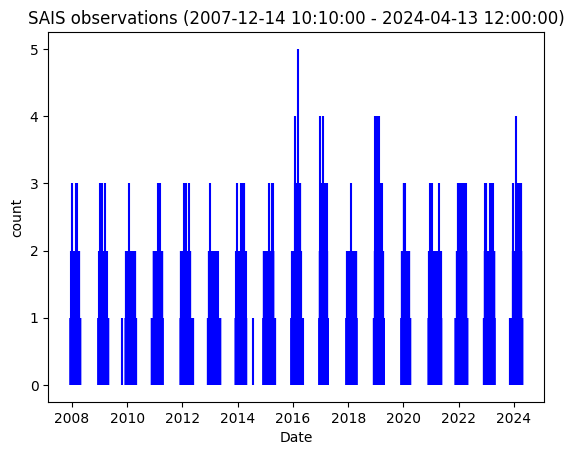

In [4]:
LatexHelpers.save_value_count_plot(
    df_sais,
    "Date",
    "sais_observation_histogram",
    path="../tex/assets/figures",
    title_prefix="SAIS observations",
)

area_summary = df_sais.groupby("Area").agg(
    total=("Forecast aval. hazard", "count"),
    min_date=("Date", "min"),
    max_date=("Date", "max"),
)
area_summary["min_date"] = area_summary["min_date"].dt.date
area_summary["max_date"] = area_summary["max_date"].dt.date

LatexHelpers.save_as_latex_table(
    area_summary,
    f"sais_area_breakdown",
    path="../tex/assets/tables",
    caption="Count of hazard levels and date ranges per area after dropping missing hazard values.",
)

LatexHelpers.save_as_latex_table(
    LatexHelpers.breakdown_per_other_column(df_sais, "Forecast aval. hazard", "Area"),
    f"sais_hazard_breakdown_per_area",
    path="../tex/assets/tables",
    caption='"Forecast aval. hazard" breakdown per area area after dropping missing hazard values.',
)

In [5]:
# df['Date'] = pd.to_datetime(df['Date'])
df_sais = df_sais.sort_values(by="Date")
df_sais["Date_diff"] = df_sais["Date"].diff().dt.days
seasons = df_sais[["Date", "Date_diff"]].sort_values(by="Date_diff", ascending=False)

date_range_years = (df_sais["Date"].max() - df_sais["Date"].min()).days / 365.25


seasons = seasons[0 : round(date_range_years)].sort_values(by="Date", ascending=True)

seasons

,Date,Date_diff
10865,2008-12-16 09:27:00,246.0
10280,2009-10-27 14:31:00,193.0
9693,2010-11-19 12:11:00,209.0
9103,2011-12-08 12:20:00,243.0
8503,2012-12-07 12:10:00,202.0
7852,2013-12-12 11:37:00,214.0
7209,2014-12-11 11:40:00,146.0
6513,2015-12-17 10:10:00,227.0
5778,2016-12-20 12:10:00,227.0
5157,2017-12-15 11:10:00,256.0


In [6]:
df2 = df_sais.sort_values(by="Date", ascending=True)
df2["Date"] = pd.to_datetime(df2["Date"])
df2["Date_diff"] = df2["Date"].diff().dt.days
gaps2 = df2[["Date", "Date_diff"]].sort_values(by="Date_diff", ascending=True)

gaps2 = gaps2[0 : round(date_range_years)].sort_values(by="Date", ascending=True)


gaps2.head()

,Date,Date_diff
11444,2007-12-14 11:36:00,0.0
3820,2019-03-25 12:00:00,0.0
3821,2019-03-25 12:00:00,0.0
3819,2019-03-26 11:00:00,0.0
3818,2019-03-26 11:13:00,0.0


In [7]:
df_sais["Date"].min()

Timestamp('2007-12-14 10:10:00')

In [8]:
# Map hazard levels to integers
map = lambda x: (
    {"low": 1, "mod": 2, "con": 3, "hig": 4, "ver": 4}[x[:3].lower()]
    if isinstance(x, str) and len(x) > 2
    else None
)
df_sais.loc[:, "mapped_hazard_forecast"] = [
    map(f) for f in df_sais.loc[:, "Forecast aval. hazard"]
]
df_sais.loc[:, "mapped_hazard_observed"] = [
    map(f) for f in df_sais.loc[:, "Observed aval. hazard"]
]

LatexHelpers.save_as_latex_table(
    LatexHelpers.breakdown_per_other_column(df_sais, "mapped_hazard_forecast", "Area"),
    f"sais_mapped_hazard_breakdown_per_area",
    path="../tex/assets/tables",
    caption=r'\detokenize{"mapped_hazard_forecast"} breakdown per area',
)

In [9]:
df_sais["Air Temp"] = pd.to_numeric(df_sais["Air Temp"], errors="coerce")
replacements_log.loc[len(replacements_log)] = [
    "Air Temp",
    f"Change datatype to numeric",
]

df_sais["Drift"] = pd.to_numeric(df_sais["Drift"], errors="coerce")
replacements_log.loc[len(replacements_log)] = ["Drift", f"Change datatype to numeric"]


# Set missing wind direction to 0 whenever corresoinding wind speed is 0
df_sais.loc[
    (df_sais["Summit Wind Dir"].isna() | df_sais["Summit Wind Dir"] < 0)
    & (df_sais["Summit Wind Speed"] == 0),
    "Summit Wind Dir",
] = 0
replacements_log.loc[len(replacements_log)] = [
    "Summit Wind Dir",
    f'Set to 0 if "Summit Wind Speed" = 0',
]
df_sais.loc[
    (df_sais["Wind Dir"].isna() | df_sais["Wind Dir"] < 0)
    & (df_sais["Wind Speed"] == 0),
    "Wind Dir",
] = 0
replacements_log.loc[len(replacements_log)] = [
    "Wind Dir",
    f'Set to 0 if "Wind Dir" = 0',
]

# Use the other temperature if missing
wh = df_sais["Summit Air Temp"].isna() & df_sais["Air Temp"].notna()
df_sais.loc[wh, "Summit Air Temp"] = df_sais.loc[wh, "Air Temp"]
wh = df_sais["Summit Air Temp"].notna() & df_sais["Air Temp"].isna()
df_sais.loc[wh, "Air Temp"] = df_sais.loc[wh, "Summit Air Temp"]
replacements_log.loc[len(replacements_log)] = [
    "Summit Air Temp",
    f'Cross fill missing values with "Air Temp"',
]
# Use other wind dir if missing
wh = df_sais["Summit Wind Dir"].isna() & df_sais["Wind Dir"].notna()
df_sais.loc[wh, "Summit Wind Dir"] = df_sais.loc[wh, "Wind Dir"]
wh = df_sais["Summit Wind Dir"].notna() & df_sais["Wind Dir"].isna()
df_sais.loc[wh, "Wind Dir"] = df_sais.loc[wh, "Summit Wind Dir"]
replacements_log.loc[len(replacements_log)] = [
    "Summit Wind Dir",
    f'Cross fill missing values with "Wind Dir"',
]

# Use other wind speed if missing
wh = df_sais["Summit Wind Speed"].isna() & df_sais["Wind Speed"].notna()
df_sais.loc[wh, "Summit Wind Speed"] = df_sais.loc[wh, "Wind Speed"]
wh = df_sais["Summit Wind Speed"].notna() & df_sais["Wind Speed"].isna()
df_sais.loc[wh, "Wind Speed"] = df_sais.loc[wh, "Summit Wind Speed"]
replacements_log.loc[len(replacements_log)] = [
    "Summit Wind Speed",
    f'Cross fill missing values with "Wind Speed"',
]

LatexHelpers.fillna_and_log_value(df_sais, "Precip Code", "0 - None", replacements_log)
LatexHelpers.fillna_and_log_value(df_sais, "Foot Pen", 0, replacements_log)
LatexHelpers.fillna_and_log_value(df_sais, "Ski Pen", 0, replacements_log)
LatexHelpers.fillna_and_log_value(df_sais, "Crystals", 0, replacements_log)
LatexHelpers.fillna_and_log_value(df_sais, "Wind Speed", 0, replacements_log)
LatexHelpers.fillna_and_log_value(df_sais, "Summit Wind Speed", 0, replacements_log)
LatexHelpers.fillna_and_log_value(df_sais, "Total Snow Depth", 0, replacements_log)
LatexHelpers.fillna_and_log_value(df_sais, "Max Temp Grad", 0, replacements_log)
LatexHelpers.fillna_and_log_value(df_sais, "Max Hardness Grad", 0, replacements_log)
LatexHelpers.fillna_and_log_value(df_sais, "Snow Index", 0, replacements_log)
LatexHelpers.fillna_and_log_value(df_sais, "Wetness", 0, replacements_log)

df_sais[["precip_code_numeric", "precip_code_desc"]] = df_sais["Precip Code"].str.split(
    "-", expand=True
)
df_sais["precip_code_numeric"] = df_sais["precip_code_numeric"].str.strip()
df_sais["precip_code_numeric"] = pd.to_numeric(
    df_sais["precip_code_numeric"], errors="coerce"
)
df_sais["precip_code_desc"] = df_sais["precip_code_desc"].str.strip()
replacements_log.loc[len(replacements_log)] = [
    "Precip Code",
    r'Split into "\detokenize{precip_code_numeric}" and "\detokenize{precip_code_desc}"',
]

df_sais = df_sais[
    [
        "Date",
        "Area",
        "Air Temp",
        "Wind Dir",
        "Wind Speed",
        "Cloud",
        "precip_code_numeric",
        "Drift",
        "Total Snow Depth",
        "Foot Pen",
        "Ski Pen",
        "Rain at 900",
        "Summit Air Temp",
        "Summit Wind Dir",
        "Summit Wind Speed",
        "Max Temp Grad",
        "Max Hardness Grad",
        "No Settle",
        "Snow Index",
        "Insolation",
        "Crystals",
        "Wetness",
        "Snow Temp",
        "mapped_hazard_forecast",
        "mapped_hazard_observed",
    ]
]

n = len(df_sais)
df_sais = df_sais.dropna()
replacements_log.loc[len(replacements_log)] = [
    "All columns",
    f"Drop {n-len(df_sais)} with missing values",
]

drop_rows_with_negatives = [
    "Wind Dir",
    "Wind Speed",
    "Cloud",
    "Total Snow Depth",
    "Foot Pen",
    "Ski Pen",
    "Summit Wind Dir",
    "Summit Wind Speed",
    "Snow Index",
    "Insolation",
    "Crystals",
    "No Settle",
    "Wetness",
]
for col in drop_rows_with_negatives:
    n = len(df_sais)
    df_sais = df_sais[df_sais[col] >= 0]
    replacements_log.loc[len(replacements_log)] = [
        col,
        f"Drop {n-len(df_sais)} negative values",
    ]

LatexHelpers.save_as_latex_table(
    replacements_log,
    "sais_replacements_log",
    path="../tex/assets/tables",
    caption="Summary of data cleansing actions on SAIS dataset",
    index=False,
)
LatexHelpers.save_text_snippet(
    f"{len(df_sais):,}", "sais_size_final", path="../tex/assets/snippets"
)

In [10]:
# split df into 1 training only Area = Torridon and the remianing ones for testing
df_test = df_sais[df_sais["Area"] == "Torridon"]
df_test.sort_values(by="Date").to_csv("../data/processed/SAIS_test.csv", index=True)
df_remaining = df_sais[df_sais["Area"] != "Torridon"]

LatexHelpers.save_text_snippet(
    f"{len(df_test):,}", "sais_size_test", path="../tex/assets/snippets"
)

df_train, df_dev = train_test_split(
    df_remaining,
    test_size=0.2,
    stratify=df_remaining[["mapped_hazard_forecast", "Area"]],
    random_state=1,
)
df_train.sort_values(by="Date").to_csv("../data/processed/SAIS_train.csv", index=True)
df_dev.sort_values(by="Date").to_csv("../data/processed/SAIS_dev.csv", index=True)

LatexHelpers.save_as_latex_table(
    LatexHelpers.breakdown_per_other_column(df_train, "mapped_hazard_forecast", "Area"),
    f"sais_mapped_hazard_breakdown_per_area_train",
    path="../tex/assets/tables",
    caption=r'Training set: \detokenize{"mapped_hazard_forecast"} breakdown per area',
)
LatexHelpers.save_text_snippet(
    f"{len(df_test):,}", "sais_size_train", path="../tex/assets/snippets"
)

LatexHelpers.save_as_latex_table(
    LatexHelpers.breakdown_per_other_column(df_dev, "mapped_hazard_forecast", "Area"),
    f"sais_mapped_hazard_breakdown_per_area_dev",
    path="../tex/assets/tables",
    caption=r'Development set: \detokenize{"mapped_hazard_forecast"} breakdown per area',
)
LatexHelpers.save_text_snippet(
    f"{len(df_test):,}", "sais_size_dev", path="../tex/assets/snippets"
)

# create a table with mapped_hazard_forecast as rows and count of each hazard in: train, dev, test as columns
hazard_breakdown = pd.DataFrame()
hazard_breakdown["Train"] = (
    df_train["mapped_hazard_forecast"].value_counts().sort_index()
)
hazard_breakdown["Dev"] = df_dev["mapped_hazard_forecast"].value_counts().sort_index()
hazard_breakdown["Test"] = df_test["mapped_hazard_forecast"].value_counts().sort_index()

hazard_breakdown.index.name = r"\detokenize{mapped_hazard_forecast}"
hazard_breakdown = hazard_breakdown.reset_index()

LatexHelpers.save_as_latex_table(
    hazard_breakdown,
    "sais_hazard_breakdown_per_split",
    path="../tex/assets/tables",
    caption=r'\detokenize{"mapped_hazard_forecast"} per dataset split',
    index=False,
)

In [11]:
df_sais["Date"] = pd.to_datetime(df_sais["Date"])

num_years = df_sais["Date"].max().year - df_sais["Date"].min().year

df_sais = df_sais.sort_values(by="Date")
df_sais["Date_diff"] = df_sais["Date"].diff().dt.days
seasons = (
    df_sais[["Date_diff", "Date"]]
    .sort_values(by="Date_diff", ascending=False)[0 : num_years - 1]
    .sort_values(by="Date")
)
seasons.drop(columns=["Date_diff"], inplace=True)


season_end = seasons["Date"].apply(lambda x: df_sais[df_sais["Date"] < x]["Date"].max())

seasons.loc[len(seasons)] = -1
seasons = seasons.shift()
seasons.iloc[0, seasons.columns.get_loc("Date")] = df_sais["Date"].min()


seasons.rename(columns={"Date": "season_start"}, inplace=True)
seasons["season_end"] = season_end
seasons.iloc[-1, seasons.columns.get_loc("season_end")] = df_sais["Date"].max()

seasons["season_start"] = pd.to_datetime(
    pd.to_datetime(seasons["season_start"]).dt.date
)
seasons["season_end"] = pd.to_datetime(pd.to_datetime(seasons["season_end"]).dt.date)

seasons["day_diff"] = (seasons["season_end"] - seasons["season_start"]).dt.days

seasons.to_csv("../data/aux/SAIS_seasons.csv", index=False)

In [ ]:
rerun = False

# long running
if rerun:

    max_lookback = round(seasons["day_diff"].mean())

    dependent_variables = list(
        set(df_train.columns.tolist())
        - set(["Area", "Date", "mapped_hazard_forecast", "mapped_hazard_observed"])
    )

    df_remaining_tab = tabularise_data_by_season_and_area(
        seasons=seasons,
        data=df_remaining,
        dependent_variables=dependent_variables,
        season_max_lookback=max_lookback,
        include_seasons_day=True,
        skip_missing_days=True,
    )

    df_train_tab = df_remaining_tab.loc[df_train.index]
    df_dev_tab = df_remaining_tab.loc[df_dev.index]

    df_train_tab.to_csv("../data/processed/SAIS_train_tabularised.csv", index=True)
    df_dev_tab.to_csv("../data/processed/SAIS_dev_tabularised.csv", index=True)

    df_test_tab = tabularise_data_by_season_and_area(
        seasons=seasons,
        data=df_test,
        dependent_variables=dependent_variables,
        season_max_lookback=max_lookback,
        include_seasons_day=True,
        skip_missing_days=True,
    )

    df_test_tab.to_csv("../data/processed/SAIS_test_tabularised.csv", index=True)

## US Forest Service National Avalanche Center

In [13]:
df_usfs = pd.read_csv("../data/raw/data-1729891347683.csv")


# delete all unnamed columns
df_usfs = df_usfs.loc[:, ~df_usfs.columns.str.contains("^Unnamed")]

df_usfs = df_usfs.dropna(subset=["danger_rating"])
# # drop rows where danger rating is one of the above values
df_usfs = df_usfs[
    ~df_usfs["danger_rating"].isin(
        [
            "-1",
            "0",
            "{hac-lutak,hac-transitional,hac-chilkat-pass}",
            "5",
            "02/01/2024 12:27",
            "13/12/2023 12:28",
            "05/12/2023 12:40",
            -1,
            0,
            ' ""Partly Cloudy""',
        ]
    )
]
df_usfs["danger_rating"] = pd.to_numeric(df_usfs["danger_rating"], errors="coerce")
df_usfs = df_usfs[
    ~df_usfs.duplicated(subset=["center_id", "start_date", "end_date"], keep="first")
]
len(df_usfs)

summary = LatexHelpers.breakdown_per_other_column(df_usfs, "danger_rating", "center_id")
summary["5"] = summary["5"].fillna(0).astype(int)
summary.index.name = r"\detokenize{danger_rating}"

LatexHelpers.save_as_latex_table(
    summary,
    f"usfs_hazard_breakdown_per_area",
    path="../tex/assets/tables",
    caption=r'US Forrestry Service dataset \detokenize{"danger_rating"} breakdown per \detokenize{"center_id"}',
)

LatexHelpers.save_text_snippet(
    f"{len(df_usfs):,}", "usfs_size_final", path="../tex/assets/snippets"
)
df_usfs.to_csv("../data/processed/USFS_data.csv", index=False)

/var/folders/ny/50qr5bj563lbm6jm3tks0w400000gn/T/ipykernel_46728/3607546213.py:1: DtypeWarning: Columns (0,2,5,6,9,10,14,18,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,163) have mixed types. Specify dtype option on import or set low_memory=False.
  df_usfs = pd.read_csv("../data/raw/data-1729891347683.csv")
